In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
!pip install progiter

# Linear regression with automatic differentiation

In [ ]:
data_points = 10
epochs = 20

In [ ]:
random.seed(4)
y = [float(random.randint(20,50)) for i in range(data_points)]
x = [float(y[i]-2 - random.randint(0, 15)) for i in range(data_points)]
print(y)
print(x)
y_copy = y
x_copy  = x

[27.0, 29.0, 23.0, 43.0, 32.0, 35.0, 24.0, 22.0, 22.0, 20.0]
[13.0, 18.0, 20.0, 34.0, 19.0, 25.0, 17.0, 17.0, 12.0, 12.0]


In [ ]:
class MyModel(keras.Model):
  def __init__(self, x, y, lr=0.01, optimizer = keras.optimizers.Adam):
    super(MyModel, self).__init__()
    self.x = tf.Variable(x, trainable=False) # if second argument ignored (which I did in my first try) model also 
                                             # "optimizes" original data points
    self.y = tf.Variable(y,trainable=False)
    self.optimizer = optimizer(lr=lr)
    self.a = tf.Variable(1.)
    self.b = tf.Variable(1.)
    self.step = 1

  def MSE(self, true, pred):
    return tf.reduce_mean(tf.square(pred-true))
  
  def predict (self, x, a, b):
    return a * self.x + b
  
  

  def train_step(self):
    with tf.GradientTape() as GT:
      #GT.watch(self.a)
      #GT.watch(self.b)
      y_pred = self.predict(self.x, self.a, self.b)
      loss = self.MSE(self.y, y_pred)
    

    gradients = GT.gradient(loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

    if(self.step%5==0):
      print("\nEpoch: ", self.step)
      print("\nLoss: ", float(loss))
      print("\nParameters: a:{:6.5f} b:{:6.5f}".format(float(self.a),float(self.b)))
      #print(self.trainable_variables)
    
    self.step+=1

    




In [ ]:
mod = MyModel(x,y, 0.5)

for epoch in range(epochs):
  mod.train_step()



In [ ]:
test=x*mod.a + mod.b
print(test.numpy())
print(y_copy)






# Tensorflow implementation of GAN

**Thumps up rules derived from original DCGAN paper**

1. Use Strided Convolutions in discriminator instead of pooling (e.g. maxpooling). Similarly, fractional stride (deconvolutional layers) can be used in the generator for upsampling.
2. No fully connected layers
3. Use batch normalization (except in the output of the generator and input to the discriminator).
4. For generators ReLU is preferred except output layer (Tanh), for discriminator LeakyReLU (with slope of 0.2) is better choice
5. Adam optimizer is better choice with lr  = 0.0002 and beta1 = 0.5

For additional tips : https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/






In [ ]:
(x_train, y_train),  (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_train, x_test = (x_train-127.5)/127.5 , (x_test-127.5)/127.5


In [ ]:
def make_generator():
  model = keras.Sequential(name="Generator")
  model.add(layers.Dense(7*7*256, input_shape=[100,]))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  model.add(layers.Reshape((7, 7, 256)))
  print("0: ", model.output_shape) # for debugging purposes
  
  #assert model.output_shape == (None, 7, 7, 256) # (batch size, h, w, channels)
  
  model.add(layers.UpSampling2D())
  print("1: ", model.output_shape)
  model.add(layers.Conv2D(128, kernel_size=3, padding="same"))
  print("2: ", model.output_shape)
  model.add(layers.BatchNormalization(momentum=0.8))
  model.add(layers.Activation("relu"))
  print("3: ", model.output_shape)
  model.add(layers.UpSampling2D())
  print("4: ", model.output_shape)
  model.add(layers.Conv2D(64, kernel_size=3, padding="same"))
  print("5: ", model.output_shape)
  model.add(layers.BatchNormalization(momentum=0.8))
  model.add(layers.Activation("relu"))
  model.add(layers.Conv2D(1, kernel_size=3, padding="same"))
  #No batch normalization according to the rule
  print("6: ", model.output_shape)
  model.add(layers.Activation("tanh"))
  return model

generator = make_generator()


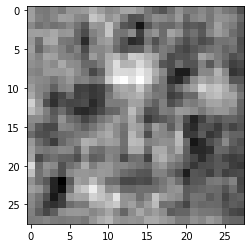

In [ ]:
random.seed(42)
first_noise = tf.random.normal([1, 100])

generated_image = generator(first_noise, training=False)
#generated_image.numpy

plt.imshow(generated_image[0, :, :, 0], cmap='gray') # first dimension is the batch size, last is channel

In [ ]:
def make_discriminator():
  model = keras.Sequential(name="Discriminator")
  model.add(layers.Conv2D(64, kernel_size=5, strides=(2,2), padding='same', input_shape=[28,28,1]))
  print(model.output_shape)
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Dropout(0.25))
  model.add(layers.Conv2D(128, kernel_size=5, strides=(2,2), padding='same'))
  model.add(layers.BatchNormalization(momentum=0.8))
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Dropout(0.25))
  model.add(layers.Conv2D(256, kernel_size=5, strides=(1,1), padding='same'))
  model.add(layers.BatchNormalization(momentum=0.8))
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Dropout(0.25))
  model.add(layers.Flatten())
  model.add(layers.Dense(1))
  return model

In [ ]:
discriminator = make_discriminator()
print(discriminator.summary())
#output = discriminator(generated_image, training=False)
#print(output)

(None, 14, 14, 64)
Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
batch_normalization_13 (Batc (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_7 (Dropout)          (None

In [ ]:

cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = keras.optimizers.Adam(2e-4, 0.5)
discriminator_optimizer = keras.optimizers.Adam(2e-4, 0.5)

In [ ]:
import math
batch_size = 256
noise_dim = 100
epochs = 30
math.ceil(len(x_train)/batch_size)

235

In [ ]:
class DCGAN(keras.Model):
  def __init__(self, generator, discriminator):
    super(DCGAN, self).__init__()
    self.generator = generator
    self.discriminator = discriminator
    self.step = 0

  def train_step(self, images):
    noise = tf.random.normal([batch_size, noise_dim])
    
    with tf.GradientTape() as gt_disc, tf.GradientTape() as gt_gen:
      
      generated_images = self.generator(noise, training=True)

      real_output = self.discriminator(images, training=True)
      fake_output = self.discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

      if(self.step % math.ceil(len(x_train)/batch_size) == 0):
        print("\n\nGenerator Loss: {}\nDisciminator Loss: {}\n".format(gen_loss, disc_loss))
      self.step+=1
      

    gradients_of_generator = gt_gen.gradient(gen_loss, self.generator.trainable_variables)
    gradients_of_discriminator = gt_disc.gradient(disc_loss, self.discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))



  
  

In [ ]:
from progiter import ProgIter
generated_images = list()
#too slow training process
data = tf.data.Dataset.from_tensor_slices(x_train).shuffle(60000).batch(batch_size)
gan_model = DCGAN(generator, discriminator)

for epoch in range(epochs):
  print("\nStarting epoch {}".format(epoch+1))
  
  
  for batch in ProgIter(data):
    gan_model.train_step(batch)
  
  result = gan_model.generator(first_noise, training=False)
  result = (result[0,:,:,0]*127.5)+127.5
  generated_images.append(result)

  




In [ ]:
generated_images = np.array(generated_images)
generated_images.shape

fig = plt.figure(figsize=(12,10))

for i in range(generated_images.shape[0]):
  plt.subplot(6,5,i+1)
  #plt.set_title('Buyuk basari')
  plt.imshow(generated_images[i,:,:], cmap='gray')

plt.show()